# LSTM for Predicting Temperature from a Multivariate Timeseries

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Import data

In [16]:
data_dir = '/home/kris/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print('columns:', header)
print('num lines:', len(lines))

columns: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
num lines: 420551


## Convert to numpy array

In [17]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
float_data[:3, :]

array([[  9.96520000e+02,  -8.02000000e+00,   2.65400000e+02,
         -8.90000000e+00,   9.33000000e+01,   3.33000000e+00,
          3.11000000e+00,   2.20000000e-01,   1.94000000e+00,
          3.12000000e+00,   1.30775000e+03,   1.03000000e+00,
          1.75000000e+00,   1.52300000e+02],
       [  9.96570000e+02,  -8.41000000e+00,   2.65010000e+02,
         -9.28000000e+00,   9.34000000e+01,   3.23000000e+00,
          3.02000000e+00,   2.10000000e-01,   1.89000000e+00,
          3.03000000e+00,   1.30980000e+03,   7.20000000e-01,
          1.50000000e+00,   1.36100000e+02],
       [  9.96530000e+02,  -8.51000000e+00,   2.64910000e+02,
         -9.31000000e+00,   9.39000000e+01,   3.21000000e+00,
          3.01000000e+00,   2.00000000e-01,   1.88000000e+00,
          3.02000000e+00,   1.31024000e+03,   1.90000000e-01,
          6.30000000e-01,   1.71600000e+02]])

## Plot of temperature timeseries

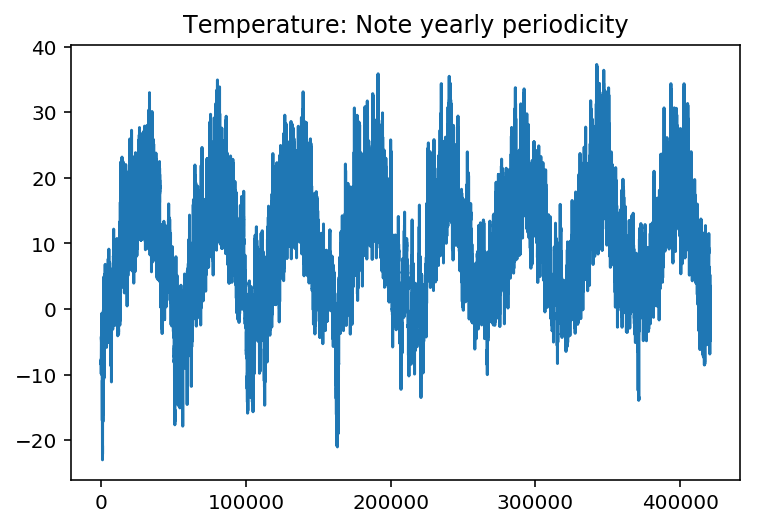

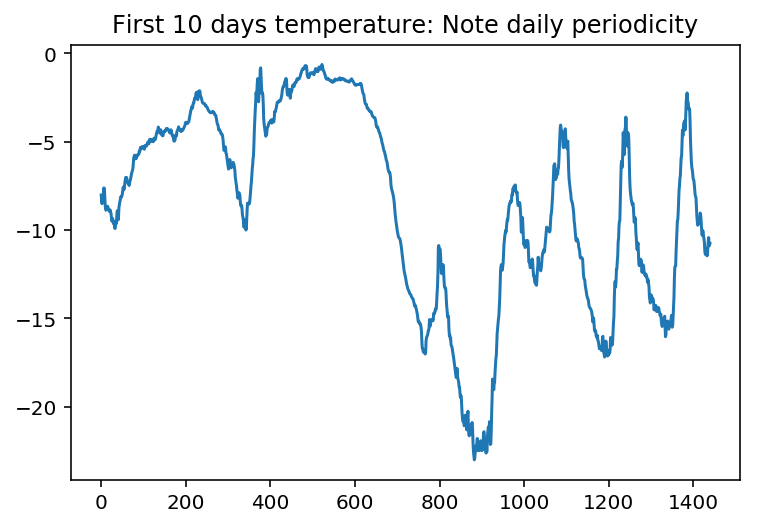

In [18]:
temp = float_data[:, 1]

plt.plot(range(len(temp)), temp)
plt.title('Temperature: Note yearly periodicity')
plt.show()

plt.plot(range(1440), temp[:1440])
plt.title('First 10 days temperature: Note daily periodicity')
plt.show();

## Problem formulation

Given data going back as far as `lookback` timesteps (a timestep is 10 minutes) and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

Our parameters will be:  
* `lookback = 720` (5 days)  
* `steps = 6` (observations sampled at one data point per hour)  
* `delay = 144` (target is 24 hours in the future)  


## Data preprocessing

Normalize each feature by subtracting mean and dividing by standard deviation. We will use the first 200,000 timesteps as training data.

In [19]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

float_data[:3, :]

array([[ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
        -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
         2.12375056, -0.72950452, -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , -1.91582958,  1.07883061,
        -1.32042698, -1.4951961 , -0.80075238, -1.49502455, -1.49932141,
         2.17199852, -0.93124017, -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, -1.92001611,  1.10872183,
        -1.32302805, -1.49757814, -0.80281834, -1.49877598, -1.50167321,
         2.18235418, -1.27614304, -1.26122763, -0.05330633]])

## Data generator

We use a Python generator that takes our array of data and yields batches of data from the recent past, along with the target. The samples in our data set are highly redundant (sample `N` and sample `N+1` will have most of their timesteps in common) - it would be inefficient to allocate every sample. Instead, we generate samples on the fly using the original data.   
  
The generator yields a tuple `(samples, targets)` where `samples` is one batch of input data and `targets` is the corresponding array of target temperatures.  
  
The generator takes as arguments:  
* `data`: the original (normalized) array of floating point data  
* `lookback`: how many timesteps should our input data go back  
* `delay`: how many timesteps in the future should our target be  
* `min_index` and `max_index`: indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment of data for validation and another for testing.  
* `shuffle`: whether to shuffle our samples or draw them in chronological order.  
* `batch_size`: the number of samples per batch
* `step`: the period (in timesteps) at which we sample the data. For this data set, `step=6` corresponds to drawing one data point every hour. 

In [20]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

## Instantiate generators for training, validation and testing

In [21]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=200001, max_index=300000, shuffle=False, step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay,
                      min_index=300001, max_index=None, shuffle=False, step=step, batch_size=batch_size)

# in order to see the whole validation set, we need to draw val_steps from val_gen:
val_steps = (300000 - 200001 - lookback) // batch_size

# in order to see the whole test set, we need to draw test_steps from test_gen:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

val_steps

769

## Create baseline model

Non machine learning based model to act as a benchmark and sanity check.  
  
Given daily periodicity in the data, our baseline will predict the temperature in 24 hours to be the same as the current temperature. Evaluate this approach using Mean Absolute Error (MAE).

In [22]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        #print('samples:', samples[1, -1])
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)
     
    
mae = evaluate_naive_method()

# convert to celsius
celsius_mae = mae * std[1]
celsius_mae

2.564887434980494

## A basic machine learning approach

Try something simple before complicated and expensive approaches, like RNNs. Further complexity should deliver better performance than this baseline. 

Here we try a simple, fully connected model. The `Flatten` layer gives us an input shape of 240 * 14 ...

In [23]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 8s - loss: 1.3796 - val_loss: 0.5758
Epoch 2/20
500/500 [==============================] - 8s - loss: 0.4383 - val_loss: 0.3208
Epoch 3/20
500/500 [==============================] - 8s - loss: 0.2939 - val_loss: 0.2985
Epoch 4/20
500/500 [==============================] - 8s - loss: 0.2679 - val_loss: 0.3231
Epoch 5/20
500/500 [==============================] - 8s - loss: 0.2526 - val_loss: 0.3120
Epoch 6/20
500/500 [==============================] - 8s - loss: 0.2436 - val_loss: 0.3061
Epoch 7/20
500/500 [==============================] - 8s - loss: 0.2362 - val_loss: 0.3306
Epoch 8/20
500/500 [==============================] - 7s - loss: 0.2324 - val_loss: 0.3544
Epoch 9/20
500/500 [==============================] - 8s - loss: 0.2255 - val_loss: 0.3222
Epoch 10/20
500/500 [==============================] - 8s - loss: 0.2212 - val_loss: 0.3432
Epoch 11/20
500/500 [==============================] - 8s - loss: 0.2164 - val_loss: 0.33

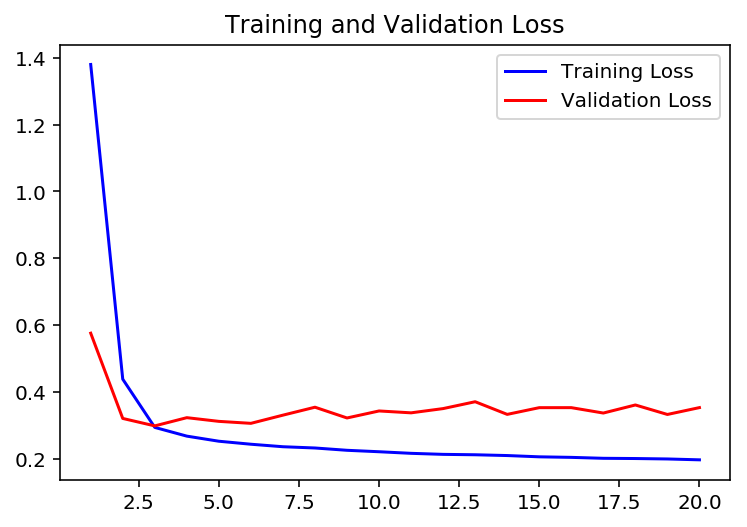

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## A first recurrent attempt - GRU

Rather than flattening the timeseries, let's look at our data as sequence.

In [25]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 92s - loss: 0.2995 - val_loss: 0.2723
Epoch 2/20
500/500 [==============================] - 92s - loss: 0.2860 - val_loss: 0.2676
Epoch 3/20
500/500 [==============================] - 92s - loss: 0.2795 - val_loss: 0.2649
Epoch 4/20
500/500 [==============================] - 92s - loss: 0.2734 - val_loss: 0.2662
Epoch 5/20
500/500 [==============================] - 92s - loss: 0.2667 - val_loss: 0.2647
Epoch 6/20
500/500 [==============================] - 93s - loss: 0.2610 - val_loss: 0.2670
Epoch 7/20
500/500 [==============================] - 93s - loss: 0.2576 - val_loss: 0.2698
Epoch 8/20
500/500 [==============================] - 94s - loss: 0.2513 - val_loss: 0.2695
Epoch 9/20
500/500 [==============================] - 93s - loss: 0.2469 - val_loss: 0.2769
Epoch 10/20
500/500 [==============================] - 94s - loss: 0.2419 - val_loss: 0.2737
Epoch 11/20
500/500 [==============================] - 96s - loss: 0.2367 - val

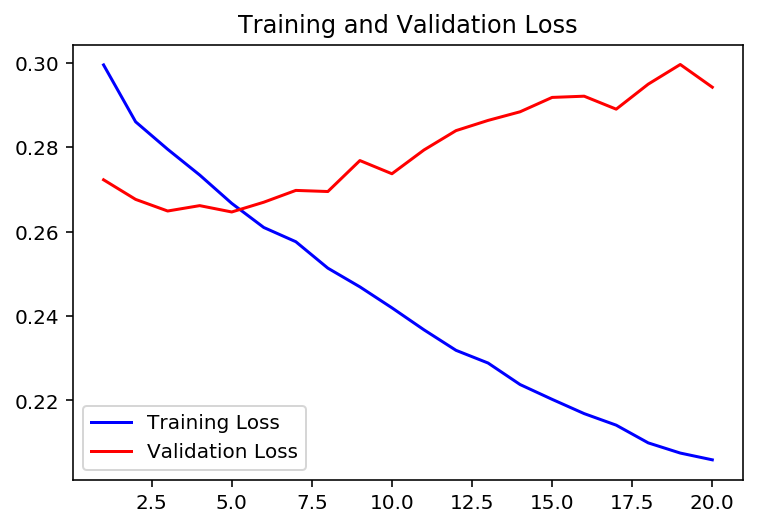

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

- This model beats our non-ML baseline, which the fully connected model was not able to do. Our new MAE is approximately 0.265, which translates to a MAE of 2.35&deg;C.

## Fighting overfitting with recurrent dropout

Our training/validation curves indicated that our model is overfitting. We can use dropout, but its application in recurrent networks needs to be considered. For instance, applying dropout *before* a recurrent layer tends to hinder learning rather than helping with overfitting. 

It turns out that the same pattern of dropped units should be applied at every timestep instead of a pattern that changes randomly from one timestep to the next. That is, the dropout mask should remain constant. 

Further, the dropout mask should be applied to the inner recurrent activations of the layer. Keras recurrent layers have two dropout-related arguments: `dropout` and `recurrent_dropout`.

Here we add dropout to our recurrent layer and train for twice as many epochs (as networks being regularized with dropout take longer to converge).

In [27]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, 
                             validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 99s - loss: 0.3361 - val_loss: 0.2758
Epoch 2/40
500/500 [==============================] - 98s - loss: 0.3116 - val_loss: 0.2726
Epoch 3/40
500/500 [==============================] - 98s - loss: 0.3063 - val_loss: 0.2715
Epoch 4/40
500/500 [==============================] - 99s - loss: 0.3034 - val_loss: 0.2675
Epoch 5/40
500/500 [==============================] - 102s - loss: 0.3000 - val_loss: 0.2720
Epoch 6/40
500/500 [==============================] - 99s - loss: 0.2998 - val_loss: 0.2657
Epoch 7/40
500/500 [==============================] - 100s - loss: 0.2956 - val_loss: 0.2650
Epoch 8/40
500/500 [==============================] - 100s - loss: 0.2940 - val_loss: 0.2662
Epoch 9/40
500/500 [==============================] - 100s - loss: 0.2936 - val_loss: 0.2655
Epoch 10/40
500/500 [==============================] - 98s - loss: 0.2930 - val_loss: 0.2633
Epoch 11/40
500/500 [==============================] - 97s - loss: 0.2906 -

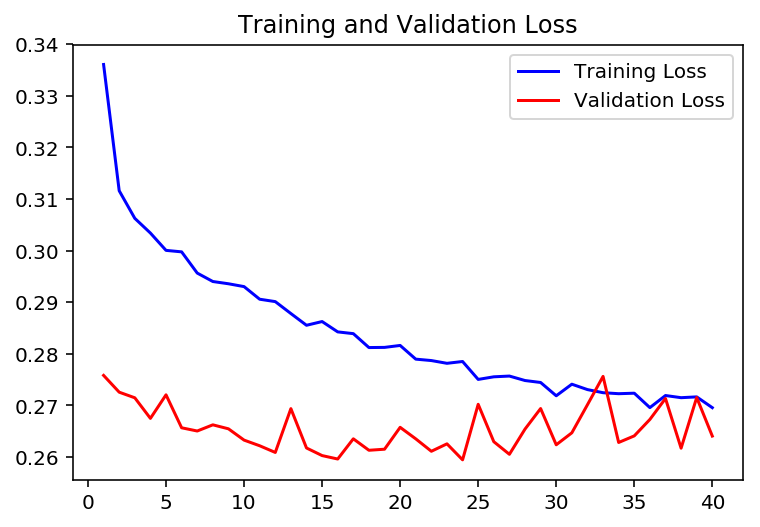

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Overfitting is no longer a problem, but we have hit a performance bottleneck. Time to start stacking layers. This requires that all intermediate layers return their full sequence of outputs rather than just the output at the last timestep. To do this, specify `return_sequences=True`

## Dropout-regularized, stacked GRU

In [29]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)


Epoch 1/40
500/500 [==============================] - 280s - loss: 0.3354 - val_loss: 0.2836
Epoch 2/40
500/500 [==============================] - 281s - loss: 0.3135 - val_loss: 0.2734
Epoch 3/40
500/500 [==============================] - 281s - loss: 0.3067 - val_loss: 0.2717
Epoch 4/40
500/500 [==============================] - 278s - loss: 0.3029 - val_loss: 0.2696
Epoch 5/40
500/500 [==============================] - 277s - loss: 0.2998 - val_loss: 0.2662
Epoch 6/40
500/500 [==============================] - 281s - loss: 0.2960 - val_loss: 0.2698
Epoch 7/40
500/500 [==============================] - 278s - loss: 0.2927 - val_loss: 0.2664
Epoch 8/40
500/500 [==============================] - 276s - loss: 0.2899 - val_loss: 0.2707
Epoch 9/40
500/500 [==============================] - 279s - loss: 0.2888 - val_loss: 0.2636
Epoch 10/40
500/500 [==============================] - 282s - loss: 0.2865 - val_loss: 0.2650
Epoch 11/40
500/500 [==============================] - 280s - loss: 0

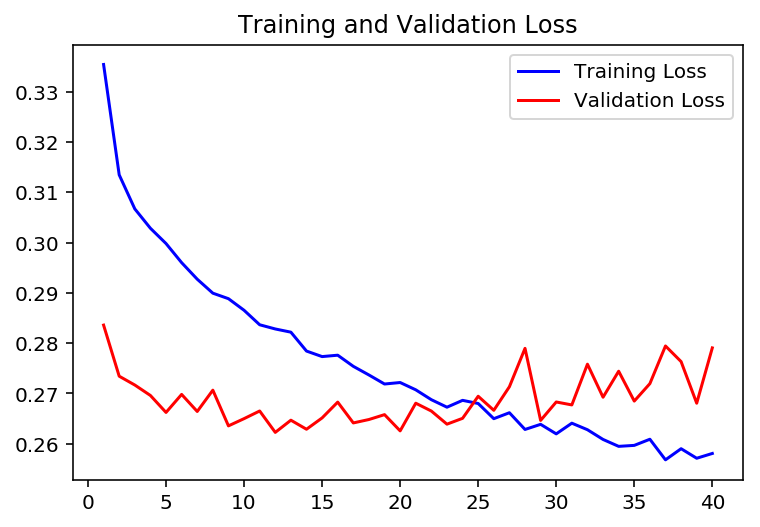

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We still aren't overfitting too badly, so there may be a case to use a bigger network - although this comes at a significant computational cost. 

## Bi-directional RNNs

Consist of two RNNs which each process the input sequence in one direction (chronologically and in reverse order). 

Useful in certain applications like natural language processing, but may not be as effective on time series forecasting where the _recent_ past is more important than the _distant_ past. 

Keras implements bi-directional RNNs via the `Bidirectional` layer. 

In [33]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 156s - loss: 0.3191 - val_loss: 0.2689
Epoch 2/40
500/500 [==============================] - 153s - loss: 0.2976 - val_loss: 0.2727
Epoch 3/40
500/500 [==============================] - 154s - loss: 0.2913 - val_loss: 0.2739
Epoch 4/40
500/500 [==============================] - 155s - loss: 0.2889 - val_loss: 0.2699
Epoch 5/40
500/500 [==============================] - 164s - loss: 0.2865 - val_loss: 0.2686
Epoch 6/40
500/500 [==============================] - 157s - loss: 0.2838 - val_loss: 0.2644
Epoch 7/40
500/500 [==============================] - 152s - loss: 0.2821 - val_loss: 0.2699
Epoch 8/40
500/500 [==============================] - 153s - loss: 0.2800 - val_loss: 0.2667
Epoch 9/40
500/500 [==============================] - 162s - loss: 0.2799 - val_loss: 0.2654
Epoch 10/40
500/500 [==============================] - 153s - loss: 0.2762 - val_loss: 0.2646
Epoch 11/40
500/500 [==============================] - 153s - loss: 0

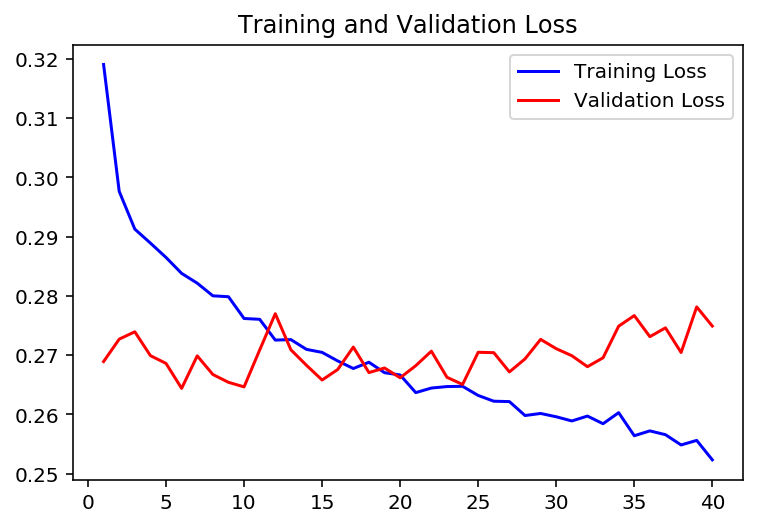

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Other things to try

* Different layer architectures
* Play with learning rate
* Use LSTM instead of GRU
* Dense layer or stack of dense layers on top of the recurrent layers

## Dense layer stacked with GRU

In [37]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=val_steps)


Epoch 1/10
500/500 [==============================] - 287s - loss: 0.3852 - val_loss: 0.2893
Epoch 2/10
500/500 [==============================] - 292s - loss: 0.3486 - val_loss: 0.2786
Epoch 3/10
500/500 [==============================] - 291s - loss: 0.3376 - val_loss: 0.3054
Epoch 4/10
500/500 [==============================] - 281s - loss: 0.3310 - val_loss: 0.3029
Epoch 5/10
500/500 [==============================] - 286s - loss: 0.3284 - val_loss: 0.3080
Epoch 6/10
500/500 [==============================] - 277s - loss: 0.3251 - val_loss: 0.3066
Epoch 7/10
500/500 [==============================] - 284s - loss: 0.3226 - val_loss: 0.3087
Epoch 8/10
500/500 [==============================] - 282s - loss: 0.3193 - val_loss: 0.3029
Epoch 9/10
500/500 [==============================] - 279s - loss: 0.3174 - val_loss: 0.3086
Epoch 10/10
500/500 [==============================] - 273s - loss: 0.3174 - val_loss: 0.3181


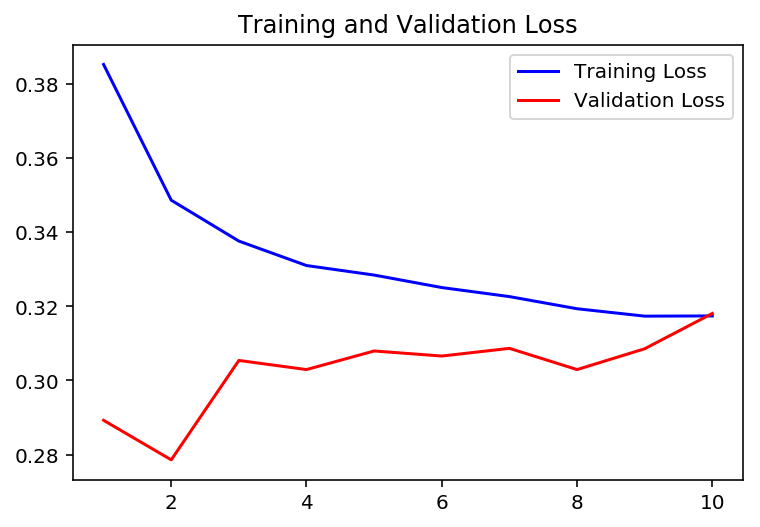

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Combine CNN and RNN to Process Long Sequences

While a 1D convnet can be used to process sequences, its lack of order sensitivity makes it less applicable to time series data. One possible solution is to use a 1D convnet as a preprocessing step before an RNN. This is particularly useful when the sequences are long (>1,000 steps), as it enables the downsampling of such sequences to something that the RNN can manage. 

Using this approach, we can look at data from longer ago or use a higher resolution:

### Set up data generators using a higher resolution

In [40]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step)

val_steps = (300000-200001-lookback) // 128
test_steps = (len(float_data)-300001-lookback) // 128


### Build model with 2x1D conv layers + GRU layer

In [42]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_15 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


### Compile and train model

In [43]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 48s - loss: 0.3375 - val_loss: 0.3102
Epoch 2/20
500/500 [==============================] - 46s - loss: 0.3070 - val_loss: 0.2762
Epoch 3/20
500/500 [==============================] - 47s - loss: 0.2948 - val_loss: 0.2769
Epoch 4/20
500/500 [==============================] - 47s - loss: 0.2856 - val_loss: 0.2730
Epoch 5/20
500/500 [==============================] - 48s - loss: 0.2781 - val_loss: 0.2732
Epoch 6/20
500/500 [==============================] - 46s - loss: 0.2712 - val_loss: 0.2872
Epoch 7/20
500/500 [==============================] - 46s - loss: 0.2627 - val_loss: 0.2752
Epoch 8/20
500/500 [==============================] - 46s - loss: 0.2607 - val_loss: 0.2799
Epoch 9/20
500/500 [==============================] - 46s - loss: 0.2544 - val_loss: 0.2812
Epoch 10/20
500/500 [==============================] - 47s - loss: 0.2520 - val_loss: 0.2800
Epoch 11/20
500/500 [==============================] - 47s - loss: 0.2475 - val

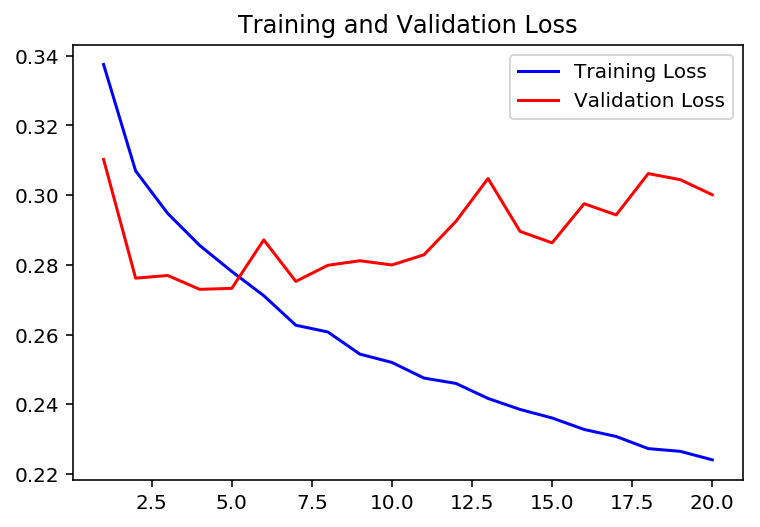

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()